# Agentic Todo List Manager - 5dGenAI Capstone Project

### Overview: 

This notebook prototypes an agentic todo list manager using LangGraph, Gemini, and Gradio. The motivation for this project is to prototype AI productivity tools adapted for users who experience overwhelm from traditional "bird's eye view" productivity apps and would prefer less visibility on tasks and events that are not immediately relevant - a "bug's eye view" for productivity, if you will, that helps users focus only on the present moment and the next transition. The app also tries to reduce barriers to task capture with an adaptive natural language interface that can estimate task priority and time needed, reducing friction to start using the tool.   

### **Core Features:**

1.  **Conversational Interface:** Interact with the agent using natural language via a Gradio chat UI.
2.  **Intelligent Task Capture:** Add tasks by describing them. LLM will estimate priority and time needed to complete if the user doesn't.
3.  **Simulated Calendar Integration:** The agent is aware of a predefined, simulated calendar to understand when you are busy or free.
4.  **Intelligent Task Suggestion:** Ask the agent "Suggest a task" or "What should I do now?". It will look at your active tasks, their priority, estimated time, and your calendar availability to suggest the most suitable task for the next free time slot.
5.  **Minimalist UI Focus:** The primary UI shows:
    * The chat interface.
    * A panel displaying the current suggestion.
    * A panel showing the time remaining until the next calendar commitment. (Element is not live, but simulates a countdown timer.)
    * A button to suggest a task.
    * A button to refresh the interface (since it's not live). 
6.  **Task Management:** Supports adding, listing, and marking tasks as complete.

**Technologies Used:**

* **LangGraph:** For orchestrating the agent's reasoning and tool use flow.
* **LangChain:** For interacting with the LLM (Gemini).
* **Google Generative AI API:** To power the natural language understanding and generation with Gemini 2.0 Flash.
* **Gradio:** To create the interactive web UI.
* **Python:** Core programming language.

This notebook demonstrates building a practical AI agent that assists with productivity by integrating task management with time awareness.

## Setup
Used the 5dGenAI Day 3 LanGraph Agent example to quickly guess which modules to uninstall before installing in the planned tech stack. We'll be using Pydantic to structure our outputs more rigorously, which should then make it easier to implement a Gradio app GUI. 

In [1]:
!pip uninstall -qqy jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai

# Install useful libraries.
!pip install -qU langchain langchain-google-genai langgraph langchain_core gradio pydantic python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.2/437.2 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.9/443.9 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42

In [2]:
# Imports
import os
import uuid
from datetime import datetime, timedelta
from typing import TypedDict, List, Optional, Annotated
import json
import warnings

# Core LangChain/LangGraph components
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END

# UI and Utilities
import gradio as gr
from kaggle_secrets import UserSecretsClient # To securely access API key

In [3]:
# API Key Setup, LLM Configuration

from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0, api_key=GOOGLE_API_KEY)
print("GenAI model configured.")

GenAI model configured.


## Core Data Structures

We define Python classes using Pydantic to represent our main data objects: `Task` and `CalendarEvent`. This should help ensure data consistency. Obviously for this simulation, the number of fields in the task is minimal - for later task diary and personalization, it would make sense to store things like the user-percieved difficulty, the completion time, and maybe even the test of the user input that created the task. 

In [4]:
# Core Data Structures 
class Task(BaseModel):
    """Represents a single task in the todo list."""
    id: str = Field(default_factory=lambda: str(uuid.uuid4()))
    description: str
    priority: int = Field(description="Priority from 1 (highest) to 5 (lowest)", ge=1, le=5)
    estimated_time_minutes: int = Field(description="Estimated time in minutes")
    added_at: datetime = Field(default_factory=datetime.now)
    completed: bool = False
    

class CalendarEvent(BaseModel):
    """Represents a block of busy time in the calendar."""
    start_time: datetime
    end_time: datetime
    summary: str

## Simulated Calendar & Task List

For this demonstration, we use a simple list to simulate our database. 

We also define a `simulated_calendar` with a few predefined events for today. The agent uses this to determine free/busy times. We can fix a "demo now" time for more predictable suggestions during testing, but otherwise it uses the actual `datetime.now()` when running.

In [5]:
# Simulated Calendar & Database

# Simulated database: a list
task_list: List[Task] = []

# Simulated calendar
_now = datetime.now()

# For consistent demo results, here's an option to declare a fixed 'now' instead.
#_now = datetime(2025,4,20,9,0)

# Helper function to create events relative to today
def create_event_time(hour, minute):
    return _now.replace(hour=hour, minute=minute, second=0, microsecond=0)

simulated_calendar: List[CalendarEvent] = [
    CalendarEvent(start_time=create_event_time(10, 0), end_time=create_event_time(11, 0), summary="Team Meeting"),
    CalendarEvent(start_time=create_event_time(13, 0), end_time=create_event_time(14, 30), summary="Project Deep Dive"),
    CalendarEvent(start_time=create_event_time(16, 0), end_time=create_event_time(16, 30), summary="Client Call"),
]

print(f"Simulated calendar events loaded relative to today ({_now.strftime('%Y-%m-%d')}).")
print(f"Current task list is empty: {not task_list}")

Simulated calendar events loaded relative to today (2025-04-29).
Current task list is empty: True


## Agent State Definition

The `AgentState` TypedDict defines the structure of the data that flows through the LangGraph graph during a single run. It holds information like the user's input, the agent's understanding (intent), extracted data, suggestions, and the final response.

In [6]:
# Agent State Definition
class AgentState(TypedDict):
    """Defines the state passed between nodes in the LangGraph."""
    user_input: Optional[str]       # Raw input from the user (can be None for programmatic triggers)
    task_id_to_complete: Optional[str] # ID of task to complete directly (e.g., from button click)
    intent: str                     # Classified intent (e.g., "add_task", "suggest_task", "complete_task_by_id", ...)
    extracted_task_info: Optional[dict] # Parsed details for a new task
    suggestion: Optional[Task]      # The task suggested by the agent
    next_event_info: Optional[dict] # Info about the next calendar block (start, end, duration_free)
    response: str                   # Formatted response for the user
    error: Optional[str]            # Any errors encountered

## Pydantic Models for Structured LLM Output

To reliably extract information from the user's natural language input, we instruct the LLM to respond in a structured format (JSON) that matches these Pydantic models. `UserIntent` captures the overall goal and any associated data, while `ParsedTaskInfo` specifically holds the details needed to create a new task.

In [7]:
# Pydantic Models for LLM Structured Output
class ParsedTaskInfo(BaseModel):
    """Information about a task extracted from user input."""
    description: str = Field(..., description="The specific action or item to be done.")
    priority: int = Field(..., ge=1, le=5, description="Priority from 1 (highest) to 5 (lowest).")
    estimated_time_minutes: int = Field(..., description="Estimated time in minutes to complete the task.")

class UserIntent(BaseModel):
    """The user's intent and any extracted task details."""
    intent: str = Field(..., description="Classify the user's primary goal. Options: 'add_task', 'suggest_task', 'list_tasks', 'complete_task', 'greet', 'goodbye', 'unknown'.")
    task_info: Optional[ParsedTaskInfo] = Field(None,description="Details of the task if intent is 'add_task'.")
    task_description_to_complete: Optional[str] = Field(None,description="The description or part of the description of the task to mark as complete, if intent is 'complete_task'.")

## Agent Node Functions

These functions represent the individual steps or capabilities of our agent. Each function takes the current `AgentState` as input and returns the updated state.

1.  **`parse_user_input`**: Uses the LLM with the structured output defined above to understand the user's message, determine their intent, and extract details like task descriptions, priorities, and time estimates.
2.  **`add_task_to_list`**: Takes the extracted task information and adds a new `Task` object to our `task_list`.
3.  **`find_next_available_slot`**: A helper function (not a graph node itself but used by `suggest_task`) that checks the `simulated_calendar` to find the next period of free time.
4.  **`suggest_task`**: The core logic for recommending a task. It checks available time, filters tasks that fit, and prioritizes them based on urgency and duration.
5.  **`format_response`**: Prepares the final text response to be shown to the user in the chat interface, handling greetings, goodbyes, errors, and confirmations.

In [8]:
# Agent Node Functions

def parse_user_input(state: AgentState) -> AgentState:
    """
    Uses LLM to understand user input, classify intent, and extract task details.
    Crucially, if priority or estimated time are not provided by the user for 
    'add_task' intent, the LLM is instructed to estimate them.
    """
    print("--- Node: parse_user_input ---")
    
    #Direct Command Check
    # If task_id_to_complete is provided in the input state, bypass LLM
    task_id = state.get('task_id_to_complete')
    if task_id:
        print(f"Direct command received: Complete task ID {task_id}")
        state['intent'] = 'complete_task_by_id'
        state['user_input'] = None # Clear user text input if processing direct command
        state['error'] = None
        return state
    
    if not llm:
        state['error'] = "LLM not configured. Cannot parse input."
        state['intent'] = "unknown"
        state['response'] = state['error']
        return state

    user_input = state['user_input']
    structured_llm = llm.with_structured_output(UserIntent)

    
    prompt = f"""Analyze the user's request regarding their todo list and calendar.

User Request: "{user_input}"

Today's Date: {datetime.now().strftime('%Y-%m-%d')}
Current Time: {datetime.now().strftime('%H:%M')} (Location: Seattle, WA, USA)


Following UserIntent schema, extract from the User Request:
intent: one of 'add_task', 'suggest_task', 'list_tasks', 'complete_task', 'greet', 'goodbye', 'unknown'.

task_info: 
    IF intent is 'add_task' you MUST populate 'task_info' field with a ParsedTaskInfo JSON object:
        description: From the User Request, extract/infer the core task as a to-do list item.
        priority: From the User Request, estimate the task's priority as an integer from 1 to 5, 1 is highest priority, 5 is the lowest priority. 
        estimated_time_minutes: From the User Request, estimate the time in minutes required to complete the task (integer).
             
        EXAMPLES: 
            If user_input is 'Prepare Q2 reports', ParsedTaskInfo is {{description:'Prepare Q2 reports',priority:2,estimated_time_minutes:180}} 
            If user_input is 'Help me remember the laundry needs folding', ParsedTaskInfo is {{description:'Fold laundry',priority:5,estimated_time_minutes:30}} 
            If user_input is 'I need to remember to send the card to Aunt Susie', ParsedTaskInfo is {{description:'Send card to Aunt Susie',priority:2,estimated_time_minutes:5}}
            If user_input is 'I want to send Aunt Susie a card'ParsedTaskInfo is {{description:'Send card to Aunt Susie',priority:3,estimated_time_minutes:30}} 
        (Notice that the last two have the same core description but because the first implied that the card was ready to be sent the time estimated was minimal and priority was increased, whereas the second implied that the card had probably not yet been purchased or written in, so a longer time would be estimated and middling priority inferred.)
        
        ELSE task_info defaults to null

task_description_to_complete:
    IF intent is 'complete_task':
        Extract the description (or keywords) of the task the user wants to complete into the `` field.
    ELSE task_description_to_complete defaults to null

Double-check - IF intent is add_task AND task_info is null THEN refer back to task_info instructions to populate the field correctly. 

Respond ONLY with the structured JSON output matching the UserIntent schema. Do not add explanations.

Example response:{{
                 "intent": "add_task",
                 "task_info": {{
                              "description": "Buy groceries for dinner",
                              "priority": 2,
                              "estimated_time_minutes": 30
                              }},
                 "task_description_to_complete": null
                 }}
"""


    try:
        result = structured_llm.invoke(prompt)
        print(f"LLM Parsing Result: {result}")

        # Update state with parsed info
        state['intent'] = result.intent
        state['extracted_task_info'] = result.task_info.dict() if result.task_info else None
        state['error'] = None # Clear previous error
        
# Handle LLM-based completion intent (user typed "complete...")
        if result.intent == 'complete_task' and result.task_description_to_complete:
             found = False
             task_description_lower = result.task_description_to_complete.lower()
             for i, task in enumerate(task_list):
                 if not task.completed and task_description_lower in task.description.lower():
                     # Instead of completing here, set the ID for the dedicated node
                     state['task_id_to_complete'] = task.id
                     state['intent'] = 'complete_task_by_id' # Route to the ID completion node
                     print(f"LLM identified task '{task.description}' (ID: {task.id}) for completion.")
                     found = True
                     break
             if not found:
                  state['response'] = f"Sorry, I couldn't find an active task matching '{result.task_description_to_complete}' based on your text."
                  print(f"Task completion failed: No match for '{result.task_description_to_complete}'")
                  state['intent'] = 'info_provided' # Go to format response directly

        elif result.intent == 'list_tasks':
            # (Logic remains the same)
            active_tasks = [t for t in task_list if not t.completed]
            if not active_tasks: state['response'] = "Your task list is empty!"
            else:
                lines = ["Here are your active tasks:"] + [f"- {t.description} (P{t.priority}, {t.estimated_time_minutes} min)" for t in sorted(active_tasks, key=lambda t: (t.priority, t.added_at))]
                state['response'] = "\n".join(lines)
            state['intent'] = 'info_provided'

    except Exception as e:
        # (Error handling remains similar)
        print(f"Error parsing input with LLM: {e}")
        error_message = f"Sorry, I had trouble understanding or processing that. Please try rephrasing. (Error detail: {e})"
        if "validation error" in str(e).lower(): error_message = f"Sorry, I couldn't extract valid task details... (Error detail: {e})"
        state['intent'] = "unknown"
        state['extracted_task_info'] = None
        state['error'] = error_message
        state['response'] = state['error']
        
    # Add a check here: If intent is add_task, ensure task_info is present AND has the required fields
    if state['intent'] == 'add_task' and (not state['extracted_task_info'] or
                                         'description' not in state['extracted_task_info'] or
                                         'priority' not in state['extracted_task_info'] or
                                         'estimated_time_minutes' not in state['extracted_task_info']):
        print(f"Error: LLM intended 'add_task' but failed to provide complete task_info: {state['extracted_task_info']}")
        state['error'] = "I understood you want to add a task, but I couldn't determine all the necessary details (description, priority, time). Please try adding the task again with more specifics."
        state['response'] = state['error']
        # Override intent to prevent routing to add_task_to_list with incomplete data
        state['intent'] = 'error_handled'


    return state

#Complete task
def complete_task_by_id(state: AgentState) -> AgentState:
    """Marks a task as complete using its ID stored in the state."""
    print("--- Node: complete_task_by_id ---")
    task_id = state.get('task_id_to_complete')
    found = False
    if task_id:
        for i, task in enumerate(task_list):
            if task.id == task_id and not task.completed:
                task_list[i].completed = True
                print(f"Task marked complete by ID: {task_id} ({task.description})")
                # Set a temporary confirmation message; the final response will come after re-suggestion
                state['response'] = f"Marked '{task.description}' as complete."
                found = True
                break
    if not found:
        print(f"Error: Task ID {task_id} not found or already completed.")
        state['error'] = f"Could not mark task as complete (ID: {task_id}). It might not exist or is already done."
        state['response'] = state['error']
        # If completion fails, maybe don't suggest? Go to format response.
        state['intent'] = 'error_handled' # Signal error occurred
    else:
        # Clear the ID and error after successful completion
        state['task_id_to_complete'] = None
        state['error'] = None
        state['intent'] = 'task_completed_suggest_next' # Signal to route to suggest_task

    return state

#Add a task
def add_task_to_list(state: AgentState) -> AgentState:
    """Adds the extracted task details (potentially estimated) to the persistent task list."""
    print("--- Node: add_task_to_list ---")
    if state.get('extracted_task_info'):
        try:
            task_info = state['extracted_task_info']

            #Use extracted/estimated values directly
            description = task_info.get('description')
            priority = task_info.get('priority')
            estimate = task_info.get('estimated_time_minutes')

            # Final check for missing essential data before creating Task object
            if not description or priority is None or estimate is None:
                 raise ValueError(f"Incomplete task information received: Desc='{description}', Prio='{priority}', Est='{estimate}'")

            new_task = Task(
                description=description,
                priority=int(priority), # Ensure integer
                estimated_time_minutes=int(estimate), # Ensure integer
            )
            task_list.append(new_task) # Append to the global list
            print(f"Task Added: {new_task}")

            # Include estimated values in confirmation if they were estimated
            # (We don't explicitly know if they were estimated vs user-provided here,
            # but the confirmation is still informative)
            state['response'] = (f"Okay, I've added '{new_task.description}' "
                                 f"(Priority {new_task.priority}, "
                                 f"{new_task.estimated_time_minutes} min) to your list.")
            print(state['response'])

            state['intent'] = 'suggest_task_after_add' # Route to suggestion node next
            state['error'] = None # Clear any previous errors if adding succeeds

        except Exception as e:
            print(f"Error creating or adding task object: {e}")
            state['error'] = f"There was an issue processing the task details: {e}"
            state['response'] = state['error']
            state['intent'] = 'error_handled' # Indicate error occurred
    else:
        # This path should ideally not be reached due to checks in parse_user_input
        print("Error: Add task node reached without extracted_task_info.")
        state['error'] = "Tried to add a task, but no task information was found in the state."
        state['response'] = "Something went wrong - I didn't have the task details to add."
        state['intent'] = 'error_handled'

    return state


# Helper Function: find_next_available_slot
def find_next_available_slot(current_time: datetime = None) -> dict:
    """
    Finds the next free time slot based on the simulated calendar.
    Returns a dictionary with 'free_from', 'free_until', 'free_duration_minutes', 'transition_reason'.
    (Code remains the same as previous version)
    """
    print("--- Helper: find_next_available_slot ---")
    if current_time is None:
        current_time = datetime.now() # Use actual current time for calculations

    sorted_events = sorted(simulated_calendar, key=lambda x: x.start_time)
    busy_until = current_time
    for event in sorted_events:
        if event.start_time <= current_time < event.end_time:
            busy_until = event.end_time
            print(f"Currently busy until {busy_until.strftime('%H:%M')} due to '{event.summary}'")
            break
    next_event_start = None
    next_event_summary = "end of known schedule"
    for event in sorted_events:
        if event.start_time >= busy_until:
            next_event_start = event.start_time
            next_event_summary = event.summary
            print(f"Next event found: '{next_event_summary}' starting at {next_event_start.strftime('%H:%M')}")
            break
    if next_event_start:
        free_duration = next_event_start - busy_until
        free_duration_minutes = int(free_duration.total_seconds() / 60)
        next_transition_time = next_event_start
        transition_reason = f"until '{next_event_summary}' starts"
    else:
        end_of_day = current_time.replace(hour=17, minute=0, second=0, microsecond=0)
        if busy_until < end_of_day:
             free_duration = end_of_day - busy_until
             free_duration_minutes = int(free_duration.total_seconds() / 60)
             next_transition_time = end_of_day
             transition_reason = "until end of workday (assumed 5 PM)"
             print(f"No further events, assuming free until end of day {next_transition_time.strftime('%H:%M')}")
        else:
             free_duration_minutes = 0
             next_transition_time = busy_until
             transition_reason = "as the workday is over or you're busy until then"
             print(f"Busy until {busy_until.strftime('%H:%M')}, which is at or after assumed end of day.")

    print(f"Slot Calculation: Free From={busy_until.strftime('%H:%M')}, Free Until={next_transition_time.strftime('%H:%M')}, Duration={max(0, free_duration_minutes)} min")
    return {
        "free_from": busy_until,
        "free_until": next_transition_time,
        "free_duration_minutes": max(0, free_duration_minutes),
        "transition_reason": transition_reason
    }



#suggest_task
def suggest_task(state: AgentState) -> AgentState:
    """Suggests the best task based on priority, time estimate, and availability."""
    print("--- Node: suggest_task ---")
    current_time = datetime.now() # Use real time now
    slot_info = find_next_available_slot(current_time)
    state['next_event_info'] = slot_info # Store for potential UI display
    available_minutes = slot_info['free_duration_minutes']
    min_task_time_threshold = 5
    if available_minutes < min_task_time_threshold:
        state['suggestion'] = None
        state['response'] = f"You only have about {available_minutes} min free {slot_info['transition_reason']}. Not enough time for most tasks. Maybe take a quick break?"
        state['intent'] = 'info_provided'
        return state
    eligible_tasks = [
        task for task in task_list
        if not task.completed and task.estimated_time_minutes <= available_minutes
    ]
    if not eligible_tasks:
        active_tasks_exist = any(not task.completed for task in task_list)
        if active_tasks_exist:
            state['suggestion'] = None
            state['response'] = f"You have {available_minutes} minutes free {slot_info['transition_reason']}, but none of your active tasks are estimated to fit in this time slot. Consider working on a smaller part of a task, or adding a smaller task."
        else:
             state['suggestion'] = None
             state['response'] = f"You have {available_minutes} minutes free {slot_info['transition_reason']} and your task list is empty! 🎉"
        state['intent'] = 'info_provided'
        return state
    eligible_tasks.sort(key=lambda t: (t.priority, t.estimated_time_minutes))
    best_task = eligible_tasks[0]
    state['suggestion'] = best_task
    state['response'] = (f"Given you have {available_minutes} minutes free {slot_info['transition_reason']}, "
                         f"I suggest working on:\n"
                         f"**Task:** '{best_task.description}'\n"
                         f"**(Priority {best_task.priority}, estimated {best_task.estimated_time_minutes} min)**")
    state['intent'] = 'info_provided'
    print(f"Suggested Task: {best_task.description}")
    return state


#format_response
def format_response(state: AgentState) -> AgentState:
    """Prepares the final response string for the user, handling various intents and errors."""
    print("--- Node: format_response ---")
    if state.get('error'):
        state['response'] = f"Error: {state['error']}"
        print(f"Final Response (Error): {state['response']}")
        return state
    if state.get('response'):
        print(f"Final Response (Pre-set): {state['response']}")
        return state
    intent = state.get('intent', 'unknown')
    if intent == 'greet':
        state['response'] = "Hello! How can I help you manage your tasks today? You can add tasks, ask for suggestions, list tasks, or mark them complete."
    elif intent == 'goodbye':
        state['response'] = "Goodbye! Stay productive!"
    elif intent == 'unknown':
         state['response'] = "Sorry, I'm not sure how to handle that request. You can ask me to 'add task [details]', 'suggest a task', 'list tasks', or 'complete task [description]'."
    else:
        state['response'] = "Okay."
    print(f"Final Response (Formatted): {state['response']}")
    return state

## Building the LangGraph

Now we define the structure of our agent using `StateGraph`.

1.  **Nodes**: We add the functions defined above (`parse_user_input`, `add_task_to_list`, `suggest_task`, `format_response`) as nodes in the graph.
2.  **Entry Point**: We set `parse_user_input` as the starting point for any user request.
3.  **Conditional Edges**: We define the logic for transitioning between nodes based on the `intent` classified by the `parse_user_input` node and the outcome of the `add_task_to_list` node.
    * After parsing, the graph routes to `add_task`, `suggest_task`, or directly to `format_response` depending on the intent.
    * After *successfully* adding a task, it routes to `suggest_task` to proactively offer the next action. If adding fails, it goes to `format_response` to show the error.
    * `suggest_task` always leads to `format_response`.
4.  **Compilation**: We compile the graph into a runnable application `agent_app`.

In [9]:
#Routing Logic
def route_after_parsing(state: AgentState):
    """Determines the next node based on the parsed intent or direct command."""
    intent = state.get('intent', 'unknown')
    print(f"Routing after parsing. Intent: {intent}")

    if state.get('error'):
        print("Routing: Parse -> Format Response (due to error in parsing)")
        return "format_response"

    #Handle direct command or LLM-identified completion
    if intent == "complete_task_by_id":
        print("Routing: Parse -> Complete Task By ID")
        return "complete_task_by_id" 

    #Handle standard intents
    if intent == "add_task":
        if state.get('extracted_task_info'):
            print("Routing: Parse -> Add Task")
            return "add_task_to_list"
        else:
            print("Routing: Parse -> Format Response (Add intent but no task info)")
            # Error message set in parse_user_input node
            return "format_response"
    elif intent in ["suggest_task", "greet"]:
        print("Routing: Parse -> Suggest Task")
        return "suggest_task"
    elif intent in ["list_tasks", "info_provided", "error_handled", "unknown", "goodbye"]:
         print(f"Routing: Parse -> Format Response (Intent: {intent})")
         return "format_response"
    else:
        print(f"Routing: Parse -> Format Response (Fallback for unexpected intent: {intent})")
        return "format_response"

def route_after_adding(state: AgentState):
     #Determines the next node after attempting to add a task.
     print("Routing after adding.")
     if state.get('error'): print("Routing: Add -> Format Response (due to error)"); return "format_response"
     else: print("Routing: Add -> Suggest Task"); return "suggest_task"

def route_after_completion(state: AgentState):
    """Determines the next node after attempting completion by ID."""
    print("Routing after completion by ID.")
    if state.get('error'):
        print("Routing: CompleteByID -> Format Response (due to error)")
        return "format_response" # If completion failed, show error
    else:
        print("Routing: CompleteByID -> Suggest Task")
        return "suggest_task" # If completion succeeded, suggest next task


# Graph Definition
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("parse_user_input", parse_user_input)
workflow.add_node("add_task_to_list", add_task_to_list)
workflow.add_node("complete_task_by_id", complete_task_by_id) # Add new node
workflow.add_node("suggest_task", suggest_task)
workflow.add_node("format_response", format_response)

# Set entry point
workflow.set_entry_point("parse_user_input")

# Define edges
workflow.add_conditional_edges(
    "parse_user_input",
    route_after_parsing,
    {
        "add_task_to_list": "add_task_to_list",
        "complete_task_by_id": "complete_task_by_id", # Route for completion
        "suggest_task": "suggest_task",
        "format_response": "format_response",
    }
)

workflow.add_conditional_edges(
    "add_task_to_list",
    route_after_adding, # Routes to suggest_task on success, format_response on error
    { "suggest_task": "suggest_task", "format_response": "format_response" }
)

#Completion Flow
workflow.add_conditional_edges(
    "complete_task_by_id",
    route_after_completion, # Routes to suggest_task on success, format_response on error
    {
        "suggest_task": "suggest_task",
        "format_response": "format_response"
    }
)


# After suggesting, always go to format the final combined response
workflow.add_edge("suggest_task", "format_response")

# End after formatting
workflow.add_edge("format_response", END)

# Compile
agent_app = workflow.compile()
print("LangGraph compiled successfully with completion-by-ID flow.")

LangGraph compiled successfully with completion-by-ID flow.


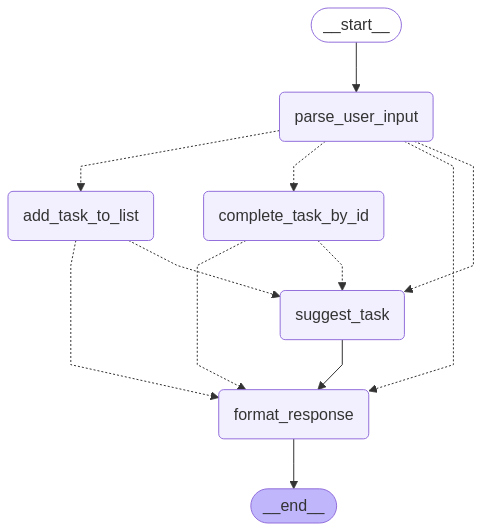

In [10]:
#Get a visual of our only-slightly labyrinthine graph
from IPython.display import Image, display

Image(agent_app.get_graph().draw_mermaid_png())

## Gradio UI Definition

Now that the app is compiled, we'll use Gradio's `Blocks` layout to create the user interface.

* A `Chatbot` component displays the conversation history.
* A `Textbox` allows the user to type messages.
* Two `Markdown` components display the **Current Suggestion** and the **Calendar Status** (time until next event). These are deliberately kept separate and minimal, focusing the user on the immediate context.
* A "Suggest Task / Refresh Status" button allows the user to explicitly trigger the suggestion logic and update the status panels.
* A "Complete Suggested Task" button allows users to complete the current task and get the next suggestion in one tap.

In [11]:
#Gradio UI Definition & Agent Runner

def run_agent_and_update_ui(message, history):
    """
    Handles user text input. Runs the agent and updates UI components,
    including the suggested_task_id_state.
    """
    print(f"\n--- Gradio: Running Agent for Input: '{message}' ---")
    suggested_task_id_out = None # Default to no suggested task ID

    if not agent_app or not llm:
         error_msg = "Agent initialization failed. Cannot process request."
         history.append((message, error_msg))
         # Return history, error messages for panels, and None for task ID state
         return history, "Error: Agent not initialized.", "Error: Agent not initialized.", None

    try:
        # Input for text-based invocation uses 'user_input'
        input_state = {"user_input": message}
        result = agent_app.invoke(input_state)
    except Exception as e:
        print(f"--- Gradio: Error invoking agent graph: {e} ---")
        error_msg = f"An error occurred: {e}"
        history.append((message, error_msg))
        return history, "Error processing request.", "Error processing request.", None

    final_response = result.get('response', "Sorry, something went wrong.")
    suggestion = result.get('suggestion') # Task object or None
    next_event_info = result.get('next_event_info')

    print(f"--- Gradio: Agent Final Response: {final_response} ---")
    print(f"--- Gradio: Agent Suggestion Object: {suggestion} ---")

    #Format Suggestion Display Panel & Update State
    suggestion_text = "**Suggested Task:**\nNo suggestion provided."
    if suggestion and isinstance(suggestion, Task):
        suggestion_text = (
            f"**Suggested Task:**\n"
            f"- **Task:** {suggestion.description}\n"
            f"- **Priority:** {suggestion.priority}\n"
            f"- **Est. Time:** {suggestion.estimated_time_minutes} min"
        )
        #Update the suggested task ID state
        suggested_task_id_out = suggestion.id
        print(f"--- Gradio: Updating suggested_task_id_state to: {suggested_task_id_out} ---")
    else:
        #If no suggestion, clear the state
        suggested_task_id_out = None
        print("--- Gradio: Clearing suggested_task_id_state (no suggestion) ---")


    #Format Timer Display Panel
    timer_text = "**Calendar Status:**\nChecking..."
    if not next_event_info and suggestion is None: # Recalculate only if needed and no suggestion info either
         print("--- Gradio: Recalculating slot info for UI ---")
         next_event_info = find_next_available_slot(datetime.now())

    if next_event_info:
        now = datetime.now()
        free_until = next_event_info.get('free_until')
        reason = next_event_info.get('transition_reason', 'unknown')
        minutes_left = 0
        if free_until and isinstance(free_until, datetime):
            time_diff = free_until - now; minutes_left = max(0, int(time_diff.total_seconds() / 60)); time_str = free_until.strftime('%H:%M')
        else: time_str = "N/A"
        timer_text = (f"**Calendar Status:**\n- **Next Transition:** {time_str}\n- **Reason:** {reason}\n- **Time Until Then:** ~{minutes_left} min")

    history.append((message, final_response))

    #Return values for ALL output components defined in the .click() or .submit() call
    #INCLUDING the gr.State component for suggested task ID
    return history, suggestion_text, timer_text, suggested_task_id_out


#Handler for the "Complete Suggested" Button
def handle_complete_suggested_click(current_suggested_id, history):
    """
    Handles the 'Complete Suggested Task' button click.
    Triggers the agent using the task_id_to_complete field.
    """
    print(f"\n--- Gradio: 'Complete Suggested' button clicked. Suggested ID: {current_suggested_id} ---")
    suggested_task_id_out = None # Will be updated by the agent run

    if not agent_app or not llm:
        error_msg = "Agent initialization failed. Cannot process request."
        #Add a system message to history
        history.append(("[System Action]", error_msg))
        return history, "Error: Agent not initialized.", "Error: Agent not initialized.", None

    if not current_suggested_id:
        warn_msg = "No task currently suggested to complete."
        history.append(("[System Action]", warn_msg))
        #Don't run agent, just update panels
        return history, "**Suggested Task:**\nNo task suggested.", "**Calendar Status:**\nN/A", None

    try:
        #Prepare input state for the agent, using the direct completion field
        input_state = {"task_id_to_complete": current_suggested_id}
        result = agent_app.invoke(input_state)
    except Exception as e:
        print(f"--- Gradio: Error invoking agent graph for completion: {e} ---")
        error_msg = f"An error occurred while completing task: {e}"
        history.append(("[System Action]", error_msg))
        return history, "Error completing task.", "Error completing task.", current_suggested_id # Keep old ID on error?

    # Process result similar to run_agent_and_update_ui
    final_response = result.get('response', "Sorry, something went wrong.")
    suggestion = result.get('suggestion')
    next_event_info = result.get('next_event_info')

    print(f"--- Gradio: Agent Final Response after completion: {final_response} ---")
    print(f"--- Gradio: Agent Suggestion Object after completion: {suggestion} ---")

    # Format Suggestion Display Panel & Update State
    suggestion_text = "**Suggested Task:**\nNo suggestion provided."
    if suggestion and isinstance(suggestion, Task):
        suggestion_text = (f"**Suggested Task:**\n- **Task:** {suggestion.description}\n- **Priority:** {suggestion.priority}\n- **Est. Time:** {suggestion.estimated_time_minutes} min")
        suggested_task_id_out = suggestion.id # Update state with NEW suggested ID
        print(f"--- Gradio: Updating suggested_task_id_state to: {suggested_task_id_out} (after completion) ---")
    else:
        suggested_task_id_out = None # Clear state if no new suggestion
        print("--- Gradio: Clearing suggested_task_id_state (no new suggestion after completion) ---")


    # Format Timer Display Panel
    timer_text = "**Calendar Status:**\nChecking..."
    if not next_event_info:
         print("--- Gradio: Recalculating slot info for UI after completion ---")
         next_event_info = find_next_available_slot(datetime.now())
    if next_event_info:
        now = datetime.now(); free_until = next_event_info.get('free_until'); reason = next_event_info.get('transition_reason', 'unknown'); minutes_left = 0
        if free_until and isinstance(free_until, datetime): time_diff = free_until - now; minutes_left = max(0, int(time_diff.total_seconds() / 60)); time_str = free_until.strftime('%H:%M')
        else: time_str = "N/A"
        timer_text = (f"**Calendar Status:**\n- **Next Transition:** {time_str}\n- **Reason:** {reason}\n- **Time Until Then:** ~{minutes_left} min")

    # Add a system message to history confirming the action attempted
    history.append(("[System Action]", f"Attempted to complete suggested task (ID: {current_suggested_id}). Agent response: {final_response}"))

    return history, suggestion_text, timer_text, suggested_task_id_out



#Build Gradio Blocks UI
with gr.Blocks(theme=gr.themes.Soft(), title="Agentic Todo List") as demo:
    gr.Markdown("# Agentic Todo List Manager")
    gr.Markdown("Manage tasks conversationally. Add tasks (describe, P1-5, time), ask for suggestions, list tasks, or complete them.")

    #Need gr.State to store the ID of the currently suggested task
    suggested_task_id_state = gr.State(value=None)

    with gr.Row():
        # Left Column: Chat Interface
        with gr.Column(scale=2):
            chatbot = gr.Chatbot([], elem_id="chatbot", type='tuples', height=600, label="Conversation", show_copy_button=True)
            chat_input = gr.Textbox(show_label=False, placeholder="Enter message or use buttons ->", container=False, scale=1)

        # Right Column: Status Panels & Buttons
        with gr.Column(scale=1):
             suggestion_display = gr.Markdown("**Suggested Task:**\nNo suggestion yet.", label="Current Suggestion")
             timer_display = gr.Markdown("**Calendar Status:**\nChecking calendar...", label="Calendar Status / Time Remaining")
             refresh_btn = gr.Button("🔄 Suggest Task / Refresh Status")
             complete_suggested_btn = gr.Button("✅ Complete Suggested Task")


    #Event Listeners:

    # User Text Input Submission
    submit_args = {
        "fn": run_agent_and_update_ui,
        "inputs": [chat_input, chatbot],
        # Output list must include the state variable to update it
        "outputs": [chatbot, suggestion_display, timer_display, suggested_task_id_state],
    }
    chat_input.submit(**submit_args)
    chat_input.submit(fn=lambda: gr.update(value=''), inputs=[], outputs=[chat_input]) # Clear input

    # Refresh Button Click
    refresh_args = {
        "fn": run_agent_and_update_ui,
        "inputs": [gr.Textbox("Suggest a task", visible=False), chatbot], # Fixed input message
        # Output list must include the state variable to update it
        "outputs": [chatbot, suggestion_display, timer_display, suggested_task_id_state],
    }
    refresh_btn.click(**refresh_args)

    # Suggested Button Click
    complete_args = {
        "fn": handle_complete_suggested_click,
        # Input is the current value of the state variable and history
        "inputs": [suggested_task_id_state, chatbot],
        # Output updates the main UI panels AND the state variable
        "outputs": [chatbot, suggestion_display, timer_display, suggested_task_id_state],
    }
    complete_suggested_btn.click(**complete_args)

print("Gradio UI defined")

Gradio UI defined


/tmp/ipykernel_13/3487499402.py:154: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  chatbot = gr.Chatbot([], elem_id="chatbot", type='tuples', height=600, label="Conversation", show_copy_button=True)


## Initialize and Launch App

Finally, we add some initial tasks to the `task_list` for demonstration purposes and launch the Gradio application.

**Note:** When running in Kaggle, Gradio will provide a public proxy link (usually ending in `gradio.live`) that you can use to access the interface.

In [12]:
# --- Initialize and Launch App ---

if __name__ == "__main__" and llm: # Only run if script is executed directly and LLM is configured
    # Add some initial tasks for demonstration
    if not task_list: # Avoid adding duplicates if the cell is re-run
        print("Adding initial demo tasks...")
        task_list.append(Task(description="Review project proposal", priority=1, estimated_time_minutes=45))
        task_list.append(Task(description="Draft team update email", priority=3, estimated_time_minutes=20))
        task_list.append(Task(description="Plan weekend trip", priority=5, estimated_time_minutes=60))
        task_list.append(Task(description="Research new tooling options", priority=2, estimated_time_minutes=120)) # Likely too long for initial slots
        task_list.append(Task(description="Quick check on urgent emails", priority=1, estimated_time_minutes=10)) # Short, high priority task
        print(f"Initial Task List ({len(task_list)} tasks):")
        for t in task_list:
            print(f"- {t.description} (P{t.priority}, {t.estimated_time_minutes}min)")
    else:
        print("Initial tasks already exist.")

    print("\nLaunching Gradio App...")
    print(f"Current time for calendar logic: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
    print(f"Simulated Calendar Events (times relative to today): {[(e.start_time.strftime('%H:%M'), e.end_time.strftime('%H:%M'), e.summary) for e in simulated_calendar]}")

    # Launch the Gradio interface.
    # `share=True` is needed to get a public link from Kaggle notebooks.
    # `inline=False` usually works better in Kaggle for launching the separate tab/link, but left True for now.
    # `debug=True` can provide more verbose logs for troubleshooting Gradio issues.
    demo.launch(share=True, inline=True, debug=False)

elif not llm:
    print("\nCannot launch Gradio app because the LLM was not configured.")
    print("Please add your GO_API_KEY to Kaggle Secrets and restart the kernel.")

Adding initial demo tasks...
Initial Task List (5 tasks):
- Review project proposal (P1, 45min)
- Draft team update email (P3, 20min)
- Plan weekend trip (P5, 60min)
- Research new tooling options (P2, 120min)
- Quick check on urgent emails (P1, 10min)

Launching Gradio App...
Current time for calendar logic: 2025-04-29 23:12
Simulated Calendar Events (times relative to today): [('10:00', '11:00', 'Team Meeting'), ('13:00', '14:30', 'Project Deep Dive'), ('16:00', '16:30', 'Client Call')]
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://6d5b8665ff6253afe1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Conclusion & Future Steps

This project illustrates that agentic AI can power a low-barrier, low-visibility productivity app that helps users focus on the current moment. Users with ADHD and/or PDA may find this particularly useful, as anxiety or overwhelm about future demands can reduce tolerance for present demands and promote avoidant behaviors like procrastination or side quests. Providing current information about the next upcoming transition can help with task engagement and time management, especially for ADHD users who struggle with time blindness and can help users emotionally prepare to transition to the next event. The AI integration really shines in the reducing barriers to task capture - just tell the agent your intention or task as you think of it and it can create and store a reasonable task item to serve up at the next opportunity. Reducing barriers to task capture benefits everyone, but especially people with ADHD or PDA who may have little patience for the busywork of entering/tracking tasks manually but also struggle to bring them to mind later. 

Future high-potential features for this application include:
* Conversational voice interface - an obvious next step from the natural language text interface to further reduce user barriers or firction in task capture.
* Personalization - add a user-informed difficulty metric to tasks and inform priority and time estimates with past task data. Track data about completed tasks to optimize suggestions to drive completion rate, especially for high difficulty tasks. For users who need choices, task selection could also offer 2 competing task suggestions instead of only 1. 
* Optional daily or weekly stand-up/stand-down conversations to go over the schedule and task list and track priorities and goals. Also a good time to adjust task priorities or problem solve tasks that get ignored.
* Proactively suggest and/or schedule personal care for users who forget lunch, can't seem to find time to shower, or need a push to sign off and go home at the end of the day.
* Catch tasks that are too large or vague and help users break them down into more concrete to-do elements, or scheduling bigger tasks as calendar events instead.
* Likewise, allow users to track partial progress on a large task or collection of tasks.
* Retrospective and diary function - show users what's been working and what hasn't. Help them remember what they've accomplished! Proactively prompt them to record if they completed other tasks while pursuing the suggested tasks. 
* Personalized coaching chat - walk users through feelings of resistance or avoidance to the current task with proven harmless coaching techniques tailored to ADHD and PDA. The LLM isn't a qualified therapist (yet) but a tuned and grounded micro-coaching implementation could help users apply various low-risk cognitive tools like reframing, contextualizing, and self-compassion to overcome inertia and avoidance to achieve their goals. 